<a href="https://colab.research.google.com/github/walterCNeto/precificador/blob/main/TestesDerivx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

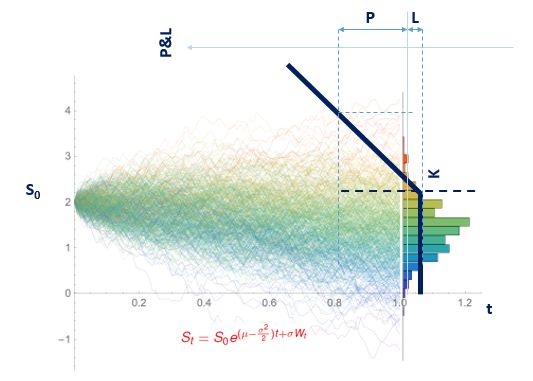

# **Instalação do módulo**

In [2]:
!pip install derivx-precificador

## **Precificação de uma CALL europeia via Monte Carlo (GBM) e comparação com Black-Scholes**

Este code demonstra como **simular** o preço de uma opção **CALL europeia** usando **Monte Carlo** sob **Geometric Brownian Motion (GBM)** e comparar com o preço **fechado** do modelo **Black-Scholes-Merton (BSM)**.

---

### 1) Problema de precificação

Queremos o preço hoje \(C_0\) de uma CALL europeia com payoff em \(T\):
$$
\text{Payoff} = (S_T - K)^+ = \max(S_T - K, 0).
$$

Sob a **medida neutra ao risco** $\mathbb{Q}$, o preço de consenso é o valor presente da esperança da realização do payoff:
$$
C_0 = e^{-rT}\,\mathbb{E}^{\mathbb{Q}}\!\left[(S_T - K)^+\right].
$$

**Parâmetros e notação:**
- \(S_T\): preço do ativo no vencimento \(T\)
- \(K\): strike
- \(r\): taxa livre de risco contínua
- Esperança sob a medida neutra ao risco: $ \mathbb{E}^{\mathbb{Q}}\!\left[\cdot\right] $.

---

### 2) Dinâmica do preço (GBM)

Assumimos que $S_t$ segue um **GBM** sob $\mathbb{Q}$:
$$
dS_t = (r - q)\,S_t\,dt + \sigma\,S_t\,dW_t,
$$
onde $q$ é o dividend yield contínuo, $\sigma$ é a volatilidade e $W_t$ é um Browniano padrão.

A solução fechada do GBM é:
$$
S_T = S_0 \,\exp\!\Big( (r-q - \frac{1}{2}\sigma^2)T + \sigma \sqrt{T}\,Z \Big), \qquad Z\sim \mathcal{N}(0,1).
$$

> Observação: para opções **não path-dependent** (como a europeia simples), pode-se calcular $S_T$ **diretamente** pela equação apresentada.

---

### 3) Estimador de Monte Carlo

Simulam-se $n$ trajetórias independentes e calcula-se a média dos payoffs descontados.

1. Para $i=1,\ldots,n$, gere $Z^{(i)} \sim \mathcal{N}(0,1)$, e calcule $S_T^{(i)}$ e então:
$$
X_i = e^{-rT}\,(S_T^{(i)} - K)^+ .
$$

2. **Preço estimado (média amostral):**
$$
\hat{C}_0 = \frac{1}{n}\sum_{i=1}^n X_i .
$$

3. **Erro-padrão (standard error):**
$$
\widehat{\mathrm{se}} = \frac{s_X}{\sqrt{n}}, \qquad
s_X^2=\frac{1}{n-1}\sum_{i=1}^n \left(X_i-\hat{C}_0\right)^2 .
$$

4. **Intervalo de confiança de 95%:**
$$
\hat{C}_0 \;\pm\; 1.96 \cdot \widehat{\mathrm{se}}.
$$

> Convergência: a precisão melhora como $\mathcal{O}(n^{-1/2})$. Para dobrar a precisão, é preciso cerca de $4\times$ mais caminhos.

---

### 4) Fórmula de Black-Scholes (referência analítica)

Para a CALL europeia:
$$
C_{\text{BS}} = S_0 e^{-qT}\,\Phi(d_1) - K e^{-rT}\,\Phi(d_2),
$$
com
$$
d_1 = \frac{\ln(S_0/K) + (r - q + \frac{1}{2}\sigma^2)T}{\sigma\sqrt{T}},
\qquad
d_2 = d_1 - \sigma\sqrt{T},
$$
e $\Phi(\cdot)$ é a CDF da normal padrão.

> Exemplo: $S_0=100$, $K=100$, $r=5\%$, $q=0\%$, $\sigma=20\%$, $T=1$ $\Rightarrow$ $C_{\text{BS}}\approx 10{,}45$.


---

### 5) Como o dicionário `spec` se conecta às fórmulas

- `engine="mc"`: usamos **Monte Carlo** para estimar \(C_0\).
- `model={"name":"gbm","r":0.05,"q":0.0,"sigma":0.2}`: parâmetros do **GBM** sob \(\mathbb{Q}\).
- `grid={"T":1.0,"steps":128}`: maturidade \(T=1\) (os *steps* são úteis para produtos dependentes do caminho).
- `S0=[100.0]`: preço inicial \(S_0\).
- `product={"style":"european","type":"european_call","asset":0,"K":100.0}`: payoff \((S_T-K)^+\).
- `n_paths=80_000`: número de amostras \(n\) (maior \(n\) implica menor \(\widehat{\mathrm{se}}\)).
- `seed=42`: reprodutibilidade.

A função `price_from_spec(spec)` implementa:
$$
\hat{C}_0 = \frac{1}{n}\sum_{i=1}^n e^{-rT}(S_T^{(i)}-K)^+,
\qquad
\widehat{\mathrm{se}} = \frac{s_X}{\sqrt{n}}.
$$

Já `bs_call_price(...)` calcula \(C_{\text{BS}}\) pela fórmula fechada acima.

**Cheque de consistência:**
$$
C_{\text{BS}} \in \left[\, \hat{C}_0 - 1.96\,\widehat{\mathrm{se}},\; \hat{C}_0 + 1.96\,\widehat{\mathrm{se}} \,\right].
$$

---

### 6) Boas práticas e extensões

- **Redução de variância**: antitéticos, variáveis de controle (usar $C_{\text{BS}}$ como controle), stratified sampling, moment matching.
- **Path-dependence**: Asians, barreiras, lookbacks exigem discretização do caminho (uso de `steps`).
- **Dividendos**: `q` cobre dividendos contínuos; para dividendos discretos, adapte o modelo.
- **Convergência**: monitore $\widehat{\mathrm{se}}$ e a largura do IC; aumente `n_paths` conforme necessário.

**Resumo**: Modela-se $S_t$ via GBM sob $\mathbb{Q}$ e precifica-se a CALL como $C_0 = e^{-rT}\,\mathbb{E}^{\mathbb{Q}}\!\left[(S_T - K)^+\right]$. Estima-se por **Monte Carlo** e valida-se contra **Black–Scholes**. Em GBM, $\,\text{MC} \to \text{BS}\,$ quando $n_{\text{paths}} \to \infty$.

---

### 7) Abaixo o code com base na biblioteca

In [3]:
from derivx import price_from_spec, bs_call_price

spec = {
  "engine": "mc",
  "model": {"name":"gbm","r":0.05,"q":0.0,"sigma":0.2},
  "grid": {"T": 1.0, "steps": 128},
  "S0": [100.0],
  "product": {"style":"european","type":"european_call","asset":0,"K":100.0},
  "n_paths": 80_000, "seed": 42,
}
p, se = price_from_spec(spec)
print("MC:", p, "±", 1.96*se)
print("BS:", bs_call_price(100, 100, r=0.05, q=0.0, sigma=0.2, T=1.0))

MC: 10.453053775923228 ± 0.10235418620772387
BS: 10.450583572185565


## CALL europeia: Monte Carlo (GBM) vs. Black–Scholes

Este bloco precifica uma **CALL europeia** de strike $K$ sobre um ativo com preço inicial $S_0$, comparando:
- **MC (Monte Carlo)** sob **GBM** (medida neutra ao risco $\mathbb{Q}$), e
- **BS (Black–Scholes)** pela fórmula analítica.

### Parâmetros usados
- $S_0 = 100$, $K = 100$, $r = 0.05$, $q = 0.00$, $\sigma = 0.20$, $T = 1$.
- Em `spec`: `engine="mc"`, modelo GBM com $(r,q,\sigma)$, `grid={"T":T,"steps":128}`, `S0=[S0]`, `product` (CALL europeia), `n_paths=80_000`, `seed=42`.

### O que o código faz
1. Monta o dicionário `spec` com a definição do problema.
2. Chama `price_from_spec(spec)` e obtém:
   - **MC**: estimativa do preço $\hat{C}_0$,
   - **se**: erro-padrão do estimador.
3. Chama `bs_call_price(...)` para o valor **BS** analítico.
4. Imprime: `MC = valor ± 1.96*se | BS = valor` (IC de 95% para o preço via MC).

### Modelo e fórmula (resumo)
- **Dinâmica (GBM) sob $\mathbb{Q}$**:
  $$
  dS_t = (r - q)\,S_t\,dt + \sigma\,S_t\,dW_t,
  \qquad
  S_T = S_0 \exp\!\Big((r-q-\tfrac{1}{2}\sigma^2)T + \sigma\sqrt{T}\,Z\Big),\; Z\sim\mathcal{N}(0,1).
  $$
- **Preço justo (definição)**:
  $$
  C_0 = e^{-rT}\,\mathbb{E}^{\mathbb{Q}}\!\left[(S_T - K)^+\right].
  $$
- **Estimador de MC** (com $X_i = e^{-rT}(S_T^{(i)}-K)^+$):
  $$
  \hat{C}_0 = \frac{1}{n}\sum_{i=1}^n X_i,
  \qquad
  \widehat{\mathrm{se}} = \frac{s_X}{\sqrt{n}},
  \qquad
  \text{IC95\%}: \hat{C}_0 \pm 1.96\,\widehat{\mathrm{se}}.
  $$
- **Black–Scholes (referência)**:
  $$
  C_{\text{BS}} = S_0 e^{-qT}\,\Phi(d_1) - K e^{-rT}\,\Phi(d_2),\quad
  d_1 = \frac{\ln(S_0/K) + (r-q+\tfrac{1}{2}\sigma^2)T}{\sigma\sqrt{T}},\;
  d_2 = d_1 - \sigma\sqrt{T}.
  $$

### Como interpretar a saída
- Se o valor **BS** cai **dentro** do intervalo `MC ± 1.96*se`, a simulação está consistente com a teoria.
- Para reduzir a largura do intervalo, aumente `n_paths` (a incerteza cai como $1/\sqrt{n}$).
- Fixar `seed` garante reprodutibilidade; `steps` é útil para produtos *path-dependent*.

> Dica: se quiser tornar a simulação mais eficiente, teste técnicas de **redução de variância** (antitéticos, variáveis de controle usando o próprio $C_{\text{BS}}$ como controle, etc.).

### Abaixo o code com base na biblioteca


In [4]:
from derivx import price_from_spec, bs_call_price

S0=K=100.0; r=0.05; q=0.0; sigma=0.2; T=1.0
spec = {
  "engine":"mc",
  "model":{"name":"gbm","r":r,"q":q,"sigma":sigma},
  "grid":{"T":T,"steps":128},
  "S0":[S0],
  "product":{"style":"european","type":"european_call","asset":0,"K":K},
  "n_paths":80_000,"seed":42,
}
pmc,se = price_from_spec(spec)
pbs = bs_call_price(S0,K,r,q,sigma,T)
print(f"MC={pmc:.4f} ± {1.96*se:.4f} | BS={pbs:.4f}")

MC=10.4531 ± 0.1024 | BS=10.4506


## PUT europeu vs. americano via PDE (Black–Scholes)

Este bloco precifica uma **PUT europeia** e uma **PUT americana** usando um solver **PDE** do modelo de **Black–Scholes**. Em puts, vale a relação:
$$
\text{Preço PUT americana} \;\ge\; \text{Preço PUT europeia}.
$$

### O que o código faz
1. Define um problema base `euro` (PUT **europeia**) com:
   - modelo GBM sob a medida neutra ao risco (parâmetros `r`, `q`, `sigma`);
   - malha temporal/espacial da PDE (`NS`, `NT`) e domínio de preço até `S_{\max} = \text{Smax\_mult}\cdot S_0`.
2. Cria `amer` copiando `euro`, mas com `style="american"` para permitir **exercício antecipado**.
3. Chama `price_from_spec(...)` para ambos e imprime: `PDE euro=...  PDE amer=... (amer >= euro)`.

> Observação sobre a API: aqui o campo `type:"european_put"` descreve o **payoff de put**; o campo `style:"european"/"american"` controla o **direito de exercício** (europeu vs. americano).

### Modelo (PDE de Black–Scholes para o valor $V(S,t)$)
Para $0<S<S_{\max}$ e $0\le t<T$:
$$
\frac{\partial V}{\partial t} \;+\; (r - q)\,S\,\frac{\partial V}{\partial S}
\;+\; \tfrac{1}{2}\sigma^2 S^2 \,\frac{\partial^2 V}{\partial S^2}
\;-\; r\,V \;=\; 0.
$$

**Condição terminal (em $t=T$)** para PUT:
$$
V(S,T) \;=\; (K - S)^+.
$$

**Condições de contorno (PUT):**
- Em $S=0$  
  • **Europeia:** $V(0,t) = K\,e^{-r(T-t)}$.  
  • **Americana:** $V(0,t) = K$ (exercício imediato é ótimo em $S=0$).
- Em $S=S_{\max}$: $V(S_{\max},t) = 0$.

**Restrição de exercício (apenas americana):**
$$
V(S,t) \;\ge\; (K - S)^+,
$$
e na **região de continuação** vale a PDE; na **região de exercício** vale $V(S,t)=(K-S)^+$. Numericamente, impõe-se a projeção $V \leftarrow \max\{V,\,(K-S)^+\}$ a cada passo de tempo.

### Grade numérica (parâmetros do spec)
- `NS=800`: número de nós em preço ($S$).  
- `NT=800`: número de passos no tempo.  
- `Smax_mult=5.0`: define $S_{\max} = 5\cdot S_0$ (aqui, $S_{\max}=500$).

Esses parâmetros controlam **estabilidade** e **convergência** da solução numérica. Aumentar `NS`/`NT` tende a melhorar a precisão (com maior custo). Escolher `S_{\max}` grande o bastante evita truncar massa de probabilidade relevante.

### Interpretação da saída
- `PDE euro` é o preço via PDE da PUT **europeia**.  
- `PDE amer` é o preço via PDE da PUT **americana** (com exercício antecipado).  
- Deve-se observar `PDE amer ≥ PDE euro`. A diferença é o **prêmio de exercício antecipado**.

### Boas práticas
- Faça **teste de convergência**: refine `NS`, `NT` e varie `Smax_mult` (ex.: 4, 6, 8).  
- Malhas **não uniformes** (mais pontos perto de $K$ e $S=0$) costumam melhorar a precisão do kink do payoff.  
- Para calls **sem dividendos** ($q=0$), tipicamente **americano = europeu**; para **puts**, o americano é **maior ou igual** ao europeu (como mostrado aqui).

### Abaixo o code



In [5]:
from derivx import price_from_spec

euro = {"engine":"pde","model":{"name":"gbm","r":0.05,"q":0.0,"sigma":0.2},
        "grid":{"T":1.0},"S0":[100.0],
        "product":{"style":"european","type":"european_put","asset":0,"K":100.0},
        "NS":800,"NT":800,"Smax_mult":5.0}

amer = {**euro, "product":{"style":"american","type":"european_put","asset":0,"K":100.0}}

pe,_ = price_from_spec(euro)
pa,_ = price_from_spec(amer)
print(f"PDE euro={pe:.4f}  PDE amer={pa:.4f}  (amer >= euro)")

PDE euro=5.6138  PDE amer=6.0744  (amer >= euro)


xxx

In [6]:
base = {"engine":"mc","model":{"name":"gbm","r":0.05,"q":0.0,"sigma":0.2},
        "grid":{"T":1.0,"steps":128},"S0":[100.0],
        "n_paths":100_000,"seed":7}

van,_   = price_from_spec({**base,"product":{"style":"european","type":"european_call","asset":0,"K":100.0}})
uo130,_ = price_from_spec({**base,"product":{"style":"european","type":"up_and_out_call","asset":0,"K":100.0,"barrier":130.0}})
uo140,_ = price_from_spec({**base,"product":{"style":"european","type":"up_and_out_call","asset":0,"K":100.0,"barrier":140.0}})
print(f"UO130={uo130:.4f} <= UO140={uo140:.4f} <= Vanilla={van:.4f}")

UO130=3.6478 <= UO140=6.0222 <= Vanilla=10.4445


In [7]:
asian,_ = price_from_spec({**base,"product":{"style":"european","type":"asian_arith_call","asset":0,"K":100.0}})
print(f"Asian={asian:.4f} <= Vanilla={van:.4f}")

Asian=5.7958 <= Vanilla=10.4445


In [8]:
def berm(ex_every):
  spec={"engine":"mc","model":{"name":"gbm","r":0.05,"q":0.0,"sigma":0.2},
        "grid":{"T":1.0,"steps":256},"S0":[100.0],
        "product":{"style":"bermudan","type":"european_put","asset":0,"K":100.0,"exercise_every":ex_every},
        "n_paths":120_000,"seed":7}
  return price_from_spec(spec)

for ex in (8,16,32):
  p,se = berm(ex)
  print(f"ex_every={ex:>2}: {p:.4f} ± {1.96*se:.4f}")

ex_every= 8: 6.0395 ± 0.0407
ex_every=16: 6.0427 ± 0.0415
ex_every=32: 6.0361 ± 0.0424


In [9]:
common={"name":"heston","r":0.05,"q":0.0,"kappa":1.5,"theta":0.04,"xi":0.5,"rho":-0.7,"v0":0.04}

fft={"engine":"fft","model":common,"grid":{"T":1.0},"S0":[100.0],
     "product":{"style":"european","type":"european_call","asset":0,"K":100.0},
     "alpha":1.5,"N":4096,"eta":0.25}

mc={"engine":"mc","model":common,"grid":{"T":1.0,"steps":512},"S0":[100.0],
    "product":{"style":"european","type":"european_call","asset":0,"K":100.0},
    "n_paths":200_000,"seed":7}

p_fft,_ = price_from_spec(fft)
p_mc,se = price_from_spec(mc)
print(f"FFT={p_fft:.4f} | MC={p_mc:.4f} ± {1.96*se:.4f}")

FFT=10.4781 | MC=10.4193 ± 0.0643


In [10]:
spec={"engine":"mc",
      "model":{"name":"gbm","r":0.05,"q":[0.01,0.03],"sigma":[0.20,0.30],
               "corr":[[1.0,0.5],[0.5,1.0]]},
      "grid":{"T":2.0,"steps":80},"S0":[100.0,120.0],
      "product":{"style":"european","type":"basket_call","weights":[0.5,0.5],"K":110.0},
      "n_paths":100_000,"seed":3}
p,se = price_from_spec(spec)
print(p, "±", 1.96*se)

15.926254233134596 ± 0.15865480424438438


In [11]:
{
  "engine":"analytic",
  "model":{"r":0.05,"q":[0.0],"sigma":[0.2],"corr":[[1.0]]},
  "grid":{"T":1.0},
  "S0":[100.0],
  "product":{"style":"european","type":"asset_or_nothing_call","asset":0,"K":100.0}
}

{'engine': 'analytic',
 'model': {'r': 0.05, 'q': [0.0], 'sigma': [0.2], 'corr': [[1.0]]},
 'grid': {'T': 1.0},
 'S0': [100.0],
 'product': {'style': 'european',
  'type': 'asset_or_nothing_call',
  'asset': 0,
  'K': 100.0}}

In [12]:
spec = {
  "engine": "analytic",
  "model": {"r": 0.05},   # ou r_curve: {"times":[...], "rates":[...]}
  "grid": {"T": 1.0},
  "S0": [],
  "product": {"style":"european","type":"fra","T1":1.0,"T2":1.5,"tau":0.5,"K":0.045,"notional":1.0}
}
pv,_ = price_from_spec(spec)

In [13]:
pv

0.0026117097297686936

In [14]:
spec = {
  "engine":"analytic","model":{"r":0.05},"grid":{"T":2.0},"S0":[],
  "product":{"style":"european","type":"swap","T0":0.0,
             "payment_times":[0.5,1.0,1.5,2.0],
             "tau":0.5, "fixed_rate":0.05, "notional":1.0}
}
pv,_ = price_from_spec(spec)

In [15]:
pv

0.0011845759417015017

In [16]:
spec = {
  "engine":"analytic","model":{"r":0.05},"grid":{"T":2.0},"S0":[],
  "product":{"style":"european","type":"cap",
             "payment_times":[0.5,1.0,1.5,2.0],
             "tau":0.5,"K":0.04,"sigma":0.20,"notional":1.0}
}
pv,_ = price_from_spec(spec)

In [17]:
pv

0.02072838335158475

In [18]:
spec = {
  "engine":"analytic","model":{"r":0.05},"grid":{"T":2.0},"S0":[],
  "product":{"style":"european","type":"payer_swaption","expiry":1.0,
             "payment_times":[1.5,2.0,2.5],"tau":0.5,"K":0.05,"sigma":0.25,"notional":1.0}
}
pv,_ = price_from_spec(spec)

In [19]:
pv

0.007230983333915667

In [21]:
from pathlib import Path
from derivx.report import plot_report

spec = {
  "engine": "analytic",
  "model": {"r": 0.05, "q": [0.0], "sigma": [0.2], "corr": [[1.0]]},
  "grid": {"T": 1.0},
  "S0": [100.0],
  "product": {"style": "european", "type": "european_call", "asset": 0, "K": 100.0},
}

out_file = "report_call.png"
rep = plot_report(spec, filename=out_file, dpi=150)

print("Preço:", rep.price, "SE:", rep.se, "PNG:", Path(out_file).resolve())

Preço: 10.450583572185565 SE: 0.0 PNG: /content/report_call.png
